# 난이도 업!!!

딥러닝에서 매우 흔하게 사용되는 분류(Classification) 문제를 다뤄보겠습니다.

우리가 학습시킬 모델은 패션 MNIST(Fashion MNIST) 데이터셋을 사용하여 의류 이미지를 10가지 카테고리(티셔츠/상의, 바지, 풀오버, 드레스, 코트, 샌들, 셔츠, 스니커즈, 가방, 발목 부츠)로 분류하는 모델입니다. 이 과정에서 다중 클래스 분류, 다층 신경망(Multi-layer Perceptron), 그리고 이미지 데이터 처리의 기본을 경험하게 될 겁니다.

학습 목표
다층 신경망 모델을 구축합니다.
패션 MNIST 데이터셋을 불러오고 전처리합니다.
다중 클래스 분류 문제에 맞는 손실 함수와 평가 지표를 사용합니다.
모델 학습 과정에서 검증(Validation) 데이터셋의 중요성을 이해합니다.

In [242]:
# 1. 필요한 라이브러리 임포트
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__) # TensorFlow 버전 확인

2.14.1


In [244]:
# 2. 데이터셋 준비: Fashion MNIST
# Fashion MNIST는 28x28 픽셀의 흑백 의류 이미지 70,000개(훈련 60,000개, 테스트 10,000개)로 구성된 데이터셋입니다.

# Fashion MNIST 데이터셋 로드 (TensorFlow 내장)
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data() # 이미 traingset, evaluation set이 정의되어 있음
# print(f"{fashion_mnist.load_data()}")

# 클래스 이름 정의 (레이블 숫자를 실제 이름으로 매핑)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 데이터 탐색: 이미지 형태 및 개수 확인
# print(f"{train_images}")
print(f"훈련 이미지 형태: {train_images.shape}") # 60000개 이미지, 각 28x28 픽셀
print(f"훈련 레이블 개수: {len(train_labels)}") # 60000개
print(f"테스트 이미지 형태: {test_images.shape}")
print(f"테스트 레이블 개수: {len(test_labels)}")

훈련 이미지 형태: (60000, 28, 28)
훈련 레이블 개수: 60000
테스트 이미지 형태: (10000, 28, 28)
테스트 레이블 개수: 10000


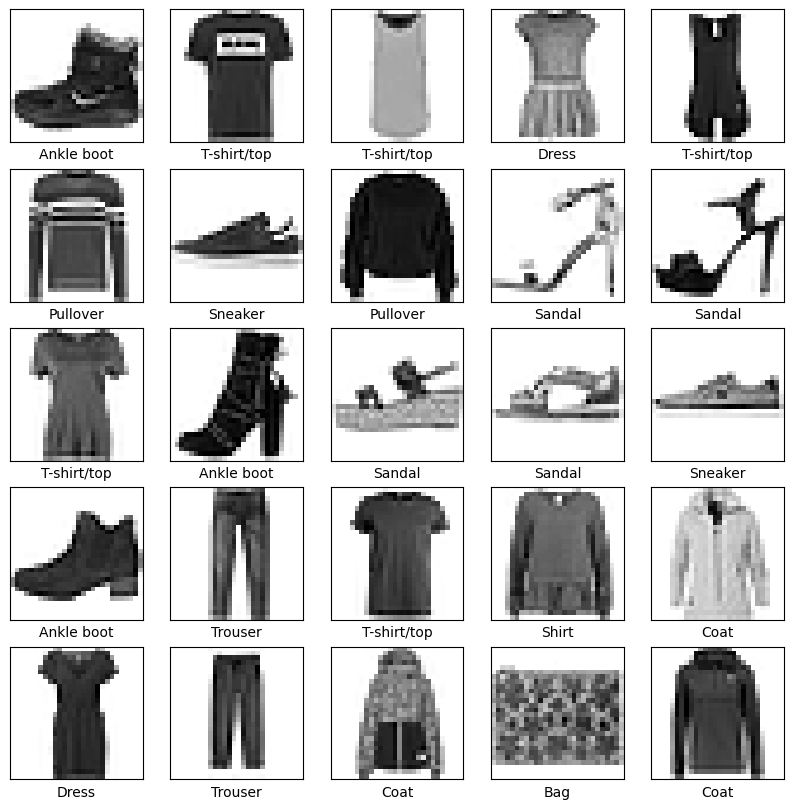

In [246]:
# 3. 데이터 전처리: 스케일링
# 신경망에 데이터를 주입하기 전에 전처리가 필요합니다. 픽셀 값은 0에서 255 사이이므로, 이를 0에서 1 사이의 값으로 **정규화(Normalization)**하여 모델 학습이 더 효율적으로 이루어지도록 합니다.

# 픽셀 값을 0-1 사이로 정규화
train_images = train_images / 255.0 # 28 x 28 x 60,000개의 픽셀을 모두 255로 나눔을 의미
test_images = test_images / 255.0

# 전처리된 이미지 확인 (선택 사항)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # cmap=plt.cm.binary의 역할: cmap=plt.cm.binary는 픽셀 값을 흑백으로 매핑하는 컬러맵을 지정합니다. 
    # 이 컬러맵은 내부적으로 가장 낮은 값(0)을 검은색으로, 가장 높은 값(1)을 흰색으로 매핑하고, 그 사이의 값들은 회색 음영으로 부드럽게 전환되도록 설계되어 있습니다.
    # imshow 함수는 입력 데이터의 최소값과 최대값을 찾아서 해당 컬러맵의 전체 범위에 매핑
    plt.imshow(train_images[i], cmap=plt.cm.binary) # matplotlib의 imshow 함수가 픽셀 값을 이미지로 렌더링
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [296]:
# *** 중요 ***
# 4. 모델 정의: 다층 신경망 (Multi-layer Perceptron)
# 이제 모델을 정의합니다. 이전 선형 회귀 모델보다 층(Layer)이 더 많아지고 복잡해집니다.

# Flatten: 28x28 픽셀의 2차원 이미지 데이터를 784개의 1차원 배열로 펼칩니다. Dense 층은 1차원 입력을 받기 때문에 이 과정이 필요합니다.
# * 28x28 흑백 이미지의 경우 (28, 28) 형태의 2차원 배열입니다. 만약 컬러 이미지라면 (28, 28, 3) 형태
# Dense (은닉층): 128개의 뉴런을 가진 완전 연결 층입니다. relu 활성화 함수를 사용하여 비선형성을 추가합니다.
# Dense (출력층): 10개의 뉴런을 가진 완전 연결 층입니다. softmax 활성화 함수를 사용하여 각 클래스에 속할 확률을 출력합니다. 10개의 뉴런은 우리가 분류할 10가지 의류 카테고리를 의미합니다.

# 1) 아래 파이썬 소스코드는 머신러닝에서 모델을 정의하는 부분이야. 사실 며칠전 너가 개발해준 샘플코드인데 한가지 궁금한게 [28, 28]이면 내가 알기로는 2차원 배열인데 왜 입력 이미지를 1차원으로 변환한다고 표현한거야?
# 신경망의 Dense 레이어는 기본적으로 1차원 벡터 형태의 입력을 기대
# Flatten 레이어는 (28, 28) 형태의 이미지를 28 * 28 = 784개의 픽셀 값을 가진 하나의 긴 1차원 벡터로 "평탄화"
# 2) 아래 소스코드에서 Flatten도 레이어고 Dense도 레이어면 내가 봤을 때 입력값에 구분할만한 값이 없는데 모델은 어떻게 은닉층, 출력층을 인식하는거야?
# 그리고 레이어는 더 많을 수도 있어?
# model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)), # 입력 이미지를 1차원으로 변환
#     keras.layers.Dense(128, activation='relu'), # 은닉층: 128개 뉴런, ReLU 활성화 함수
#     keras.layers.Dense(10, activation='softmax') # 출력층: 10개 뉴런, Softmax 활성화 함수
# ])
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28), name='flatten_layer'), # 층에 이름을 부여하여 쉽게 참조
    tf.keras.layers.Dense(units=128, activation='relu', name='hidden_layer'), # 층에 이름을 부여
    tf.keras.layers.Dense(units=10, activation='softmax', name='output_layer') # 층에 이름을 부여
])

1. 은닉층 (Dense(128, activation='relu'))의 출력 (128개의 뉴런)
먼저, Flatten(input_shape=(28, 28)) 레이어를 통해 28x28 픽셀의 이미지(총 784 픽셀)가 1차원 배열(784개의 값)로 변환되어 은닉층의 입력으로 들어옵니다.
은닉층 Dense(128, activation='relu')는 다음과 같은 작업을 수행합니다.
선형 변환 (Linear Transformation): 입력된 784개의 값 각각에 대해 **가중치(Weight)**가 곱해지고, 모든 곱셈 결과가 더해진 후 **편향(Bias)**이 더해집니다. 
이 과정이 128개의 뉴런 각각에 대해 독립적으로 일어납니다.
간단히 말해, 각 뉴런은 입력 데이터의 특정 패턴을 인식하려고 합니다. 
예를 들어, 첫 번째 은닉층 뉴런은 이미지의 특정 부분에 수직선이 있는지, 두 번째 뉴런은 특정 부분에 곡선이 있는지 등을 보는 식입니다.
수학적으로 표현하면, 각 뉴런의 선형 출력 (z)은 다음과 같습니다: z=(입력 벡터×가중치 행렬)+편향 벡터 여기서 입력 벡터는 784개의 값을 가지고, 
가중치 행렬은 (784, 128) 크기이며, 편향 벡터는 128개의 값을 가집니다. 결과적으로 128개의 z 값이 나옵니다.
ReLU 활성화 함수 적용: 선형 변환을 통해 얻은 128개의 각각의 값(z)에 대해 ReLU(Rectified Linear Unit) 활성화 함수가 적용됩니다. 
    
ReLU 함수는 매우 간단합니다 : f(x)=max(0,x)

즉, 입력값이 0보다 작으면 0으로 만들고, 0보다 크면 그 값을 그대로 유지합니다.
이 활성화 함수는 신경망에 비선형성을 도입하여 모델이 더 복잡한 패턴을 학습할 수 있게 해줍니다. 
128개의 뉴런 각각에서 나온 이 ReLU를 통과한 값들이 다음 층(출력층)의 입력이 됩니다.
    
결과: 은닉층을 통과하면 **128개의 활성화된 값(feature 또는 특징)**이 생성됩니다. 
이 128개의 값은 원본 이미지의 다양한 추상적인 특징(예: 선, 모서리, 질감 등)을 나타낸다고 볼 수 있습니다.

2. 출력층 (Dense(10, activation='softmax'))으로의 연결
이제 은닉층에서 나온 128개의 활성화된 값이 출력층 Dense(10, activation='softmax')의 입력으로 들어갑니다.
출력층은 다음과 같은 작업을 수행합니다.
선형 변환 (Linear Transformation): 은닉층과 마찬가지로, 입력된 128개의 값 각각에 대해 새로운 **가중치(Weight)**가 곱해지고, 
모든 곱셈 결과가 더해진 후 **편향(Bias)**이 더해집니다. 이 과정이 10개의 뉴런 각각에 대해 독립적으로 일어납니다.
여기서 10개의 뉴런은 우리가 분류하고자 하는 10가지 패션 MNIST 클래스(T-Shirt/top, Trouser 등)에 해당합니다.
각 뉴런은 이 128개의 특징을 조합하여 특정 클래스에 속할 확률을 예측하기 위한 원시 값(logits)을 계산합니다.

Softmax 활성화 함수 적용: 10개의 선형 출력 값에 대해 Softmax 활성화 함수가 적용됩니다. Softmax 함수의 목적은 다음과 같습니다:
10개의 실수 값을 모두 0과 1 사이의 값으로 변환합니다. 이 10개의 값들의 총합이 1이 되도록 만듭니다.
이는 각 뉴런의 출력을 해당 클래스에 속할 확률로 해석할 수 있게 해줍니다. 가장 높은 확률을 가진 뉴런의 인덱스가 최종 예측 클래스가 됩니다.

결과: 출력층을 통과하면 10개의 값이 생성되며, 이 값들은 입력 이미지가 10가지 패션 MNIST 클래스 각각에 속할 확률을 나타냅니다. 
예를 들어, [0.01, 0.02, 0.90, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]과 같은 출력이 나왔다면, 
세 번째 클래스(Pullover)일 확률이 90%로 가장 높다는 것을 의미합니다.

In [298]:
# 5. 모델 컴파일: 학습 전략 설정
# 분류 문제에 맞는 옵티마이저, 손실 함수, 평가 지표를 설정합니다.

# 옵티마이저: adam (이전과 동일하게 효율적인 옵티마이저)
# 손실 함수: sparse_categorical_crossentropy
# 이 손실 함수는 정수 레이블(0, 1, 2, ... 9)을 가진 다중 클래스 분류 문제에 적합합니다. 만약 레이블이 원-핫 인코딩(예: [0,0,1,0,0,...])되어 있다면 categorical_crossentropy를 사용합니다.
# 평가 지표: accuracy (정확도)
# 모델이 얼마나 정확하게 분류하는지를 측정하는 가장 일반적인 지표입니다.

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


모델 학습 시작...
Epoch 1/10
1500/1500 [==============================] - 1s 711us/step - loss: 0.5228 - accuracy: 0.8153 - val_loss: 0.4131 - val_accuracy: 0.8537
Epoch 2/10
1500/1500 [==============================] - 1s 652us/step - loss: 0.3872 - accuracy: 0.8605 - val_loss: 0.3892 - val_accuracy: 0.8631
Epoch 3/10
1500/1500 [==============================] - 1s 637us/step - loss: 0.3458 - accuracy: 0.8730 - val_loss: 0.3575 - val_accuracy: 0.8709
Epoch 4/10
1500/1500 [==============================] - 1s 613us/step - loss: 0.3219 - accuracy: 0.8822 - val_loss: 0.3274 - val_accuracy: 0.8834
Epoch 5/10
1500/1500 [==============================] - 1s 655us/step - loss: 0.2997 - accuracy: 0.8911 - val_loss: 0.3315 - val_accuracy: 0.8828
Epoch 6/10
1500/1500 [==============================] - 1s 649us/step - loss: 0.2867 - accuracy: 0.8932 - val_loss: 0.3228 - val_accuracy: 0.8821
Epoch 7/10
1500/1500 [==============================] - 1s 649us/step - loss: 0.2723 - accuracy: 0.8981 - val_l

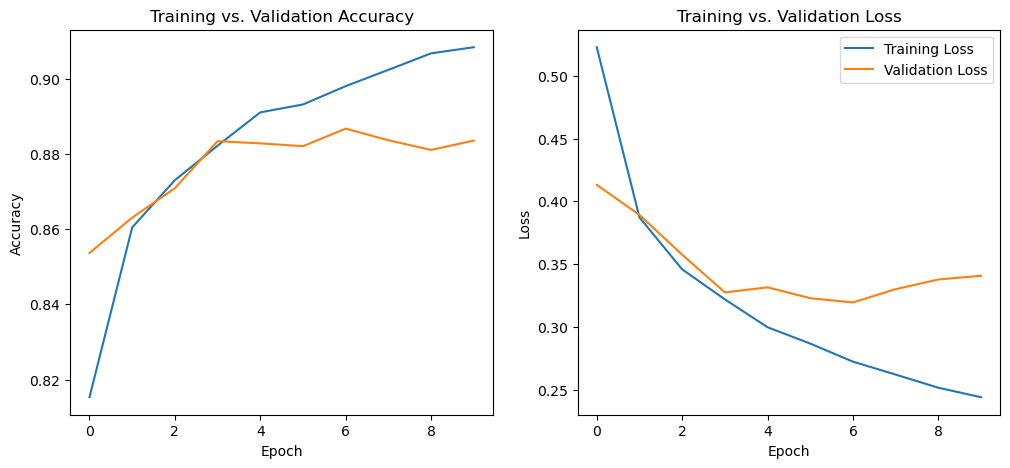

In [300]:
# 6. 모델 학습: 훈련 데이터로 모델 훈련
# 이제 fit() 메서드를 호출하여 모델을 훈련합니다. 이번에는 validation_split 매개변수를 사용하여 훈련 데이터의 일부를 검증 세트로 분리합니다.
# 에포크(Epochs): 전체 훈련 데이터셋을 몇 번 반복하여 학습할 것인지 지정합니다.
# 검증 세트(Validation Set): 모델이 훈련 데이터를 학습하는 동안, 검증 세트의 성능을 모니터링하여 과적합(Overfitting) 여부를 확인할 수 있습니다. 모델이 훈련 데이터에서는 잘 작동하지만, 한 번도 보지 못한 검증 데이터에서는 성능이 떨어지는 것이 과적합의 징후입니다.
# model.fit() 함수의 batch_size 인자가 명시되지 않으면 Keras는 기본적으로 32의 배치 크기를 사용

print("\n모델 학습 시작...")
history = model.fit(train_images, train_labels, epochs=10, validation_split=0.2) # 20%를 검증 세트로 사용
print("모델 학습 완료!")

# 학습 및 검증 정확도/손실 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.legend()
plt.title('Training vs. Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()

In [308]:
# --- 특정 층의 출력을 보는 새로운 모델 정의 ---

# 1. Flatten 층의 출력 보기
flatten_output_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('flatten_layer').output)
# 테스트 이미지 중 첫 번째 이미지로 Flatten 층의 출력 확인
sample_image = test_images[0:1] # 첫 번째 이미지를 배치 형태로 준비 (shape: (1, 28, 28))
flattened_output = flatten_output_model.predict(sample_image)
print(f"\nFlatten 층 출력 Shape: {flattened_output.shape}") # (1, 784)
print(f"Flatten 층 출력 예시 (첫 10개 픽셀): {flattened_output[0, :10]}")
# print(f"Flatten 층 출력 예시 (첫 10개 픽셀): {flattened_output[0, :]}")


# 2. Dense (hidden_layer) 층의 출력 보기
hidden_output_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('hidden_layer').output)
# Flatten 층을 거쳐 hidden_layer의 출력 확인
hidden_layer_output = hidden_output_model.predict(sample_image)
print(f"\nHidden 층 출력 Shape: {hidden_layer_output.shape}") # (1, 128)
print(f"Hidden 층 출력 예시 (첫 10개 값): {hidden_layer_output[0, :10]}")
# print(f"Hidden 층 출력 예시 (첫 10개 값): {hidden_layer_output[0, :]}")


# 3. Dense (output_layer) 층의 출력 보기 (실제 예측 확률)
output_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('output_layer').output)
# Hidden 층을 거쳐 output_layer의 출력 확인
final_output = output_layer_model.predict(sample_image)
print(f"\nOutput 층 (Softmax) 출력 Shape: {final_output.shape}") # (1, 10)
print(f"Output 층 출력 예시 (10개 클래스 확률): {final_output[0]}")
print(f"예측된 클래스 (가장 높은 확률): {np.argmax(final_output[0])}")

# --- 여기까지 중간 출력 확인 부분 ---

1/1 [==============================] - 0s 16ms/step

Flatten 층 출력 Shape: (1, 784)
Flatten 층 출력 예시 (첫 10개 픽셀): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 17ms/step

Hidden 층 출력 Shape: (1, 128)
Hidden 층 출력 예시 (첫 10개 값): [0.9132149 0.        0.        0.        0.        0.        0.
 0.        0.        0.       ]
1/1 [==============================] - 0s 17ms/step

Output 층 (Softmax) 출력 Shape: (1, 10)
Output 층 출력 예시 (10개 클래스 확률): [1.1627724e-05 5.6134417e-09 9.9422239e-09 8.2503249e-08 8.2151821e-08
 4.8313523e-05 3.5342106e-07 8.1601091e-02 1.8556657e-06 9.1833657e-01]
예측된 클래스 (가장 높은 확률): 9


In [290]:
# 7. 모델 평가: 테스트 데이터로 모델 성능 측정
# 모델이 훈련되지 않은 테스트 데이터셋에 대해 얼마나 잘 작동하는지 평가합니다. 이것이 모델의 일반화(Generalization) 성능을 나타내는 중요한 지표입니다.

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"\n테스트 정확도: {test_acc:.4f}")
print(f"테스트 손실: {test_loss:.4f}")

313/313 - 0s - loss: 0.3707 - accuracy: 0.8758 - 144ms/epoch - 459us/step

테스트 정확도: 0.8758
테스트 손실: 0.3707


313/313 [==============================] - 0s 342us/step

첫 번째 테스트 이미지의 예측: [1.88198390e-09 1.15342059e-11 2.03898814e-10 2.90623103e-12
 1.15972206e-07 1.99082006e-05 2.78066121e-08 4.68913931e-04
 2.46354332e-08 9.99511003e-01]
첫 번째 테스트 이미지의 예측 클래스 (가장 높은 확률): 9
첫 번째 테스트 이미지의 실제 레이블: 9
예측 클래스 이름: Ankle boot
실제 클래스 이름: Ankle boot


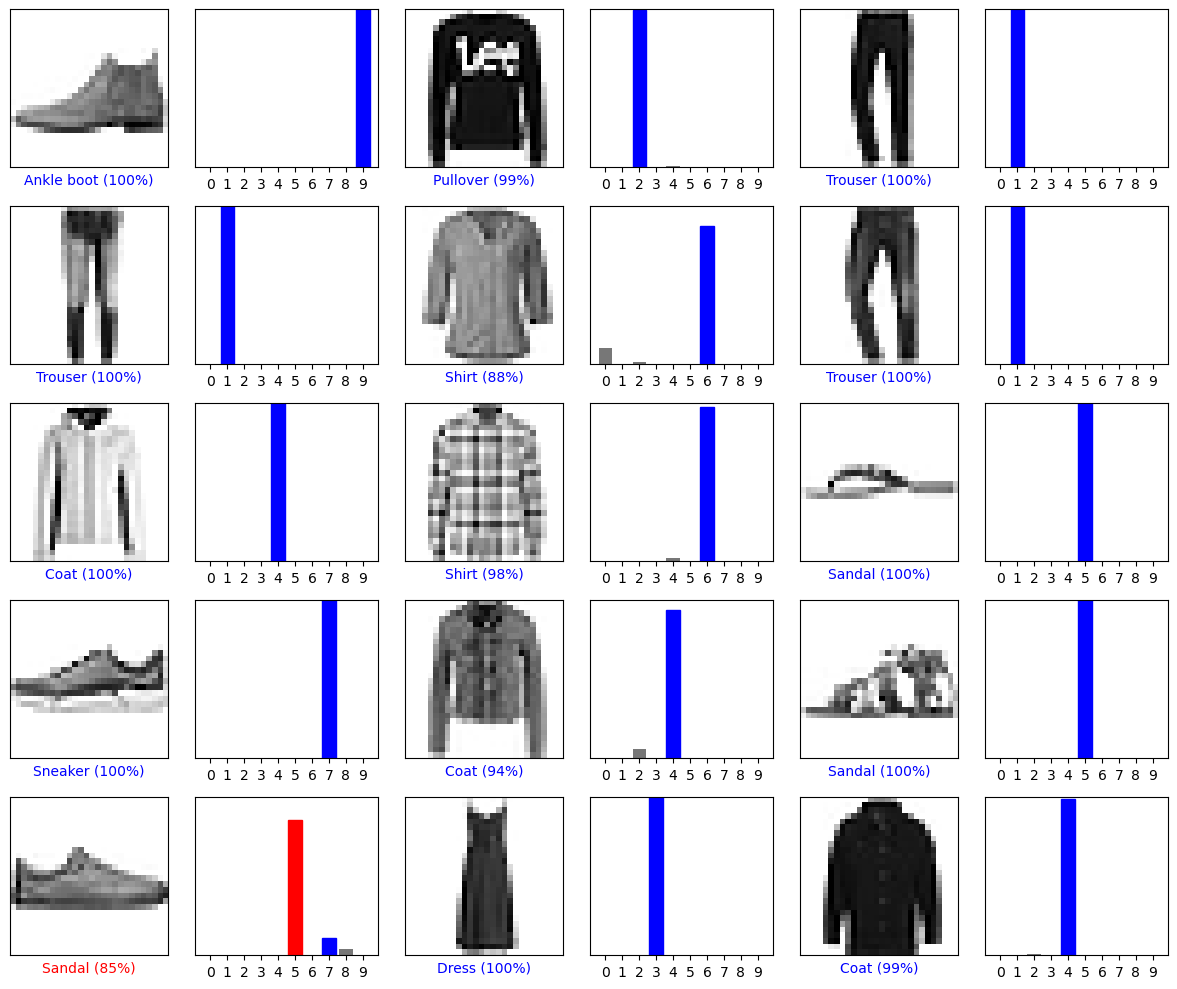

In [292]:
# 8. 예측 수행: 새로운 이미지 분류
# 학습된 모델을 사용하여 새로운 이미지에 대한 예측을 수행합니다.

predictions = model.predict(test_images)

# 첫 번째 테스트 이미지의 예측 결과 확인
print(f"\n첫 번째 테스트 이미지의 예측: {predictions[0]}") # 각 클래스별 확률
print(f"첫 번째 테스트 이미지의 예측 클래스 (가장 높은 확률): {np.argmax(predictions[0])}")
print(f"첫 번째 테스트 이미지의 실제 레이블: {test_labels[0]}")
print(f"예측 클래스 이름: {class_names[np.argmax(predictions[0])]}")
print(f"실제 클래스 이름: {class_names[test_labels[0]]}")


# 예측 시각화 함수
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue' # 맞으면 파란색
    else:
        color = 'red' # 틀리면 빨간색

    plt.xlabel(f"{class_names[predicted_label]} ({100*np.max(predictions_array):.0f}%)",
               color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

# 몇 가지 예측 결과 시각화
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

이전 코드와의 주요 차이점 및 새로운 개념
데이터셋:

Fashion MNIST: 실제 이미지 데이터를 사용하며, 훈련/테스트 세트가 미리 나뉘어져 있습니다.
다중 클래스: 이전에는 하나의 숫자(y)를 예측했지만, 이제는 10가지 클래스 중 하나를 예측합니다.
데이터 전처리:

정규화: 픽셀 값을 0-255에서 0-1로 스케일링하는 과정이 추가되었습니다. 이는 신경망 학습의 안정성과 효율성을 높입니다.
모델 구조 (다층 신경망):

Flatten 층: 2차원 이미지를 1차원 벡터로 변환합니다. Dense 층이 1차원 입력을 받기 위함입니다.
은닉층 (Dense(128, activation='relu')):
Dense 층이 하나 더 추가되어 **"깊이"**를 가집니다. 이렇게 여러 층을 쌓은 모델을 "딥러닝(Deep Learning)" 모델이라고 부릅니다.
활성화 함수(relu): 이전에 설명했던 Dense 층은 선형 변환(y=Wx+b)만 수행합니다. relu (Rectified Linear Unit)와 같은 비선형 활성화 함수를 각 층 사이에 추가함으로써, 모델이 복잡하고 비선형적인 패턴을 학습할 수 있게 됩니다.
출력층 (Dense(10, activation='softmax')):
units=10: 10가지 클래스 각각에 대한 출력 뉴런을 가집니다.
softmax 활성화 함수: 출력 뉴런들의 값을 모두 0과 1 사이의 확률 값으로 변환하고, 이 확률 값들의 합이 항상 1이 되도록 합니다. 가장 높은 확률을 가진 클래스가 모델의 최종 예측이 됩니다.
컴파일 (손실 함수):

sparse_categorical_crossentropy: 다중 클래스 분류 문제에 사용되는 손실 함수입니다. 각 클래스 레이블이 정수(0, 1, ..., 9)로 주어질 때 적합합니다. 모델이 예측한 확률 분포와 실제 정답 클래스 사이의 차이를 측정합니다.
모델 학습 (검증 세트):

validation_split=0.2: 훈련 데이터의 20%를 자동으로 분리하여 검증 세트로 사용합니다. 이 검증 세트는 모델이 학습하는 동안 한 번도 보지 못한 데이터에 대해 모델의 성능이 어떻게 변하는지 모니터링하는 데 사용됩니다.
과적합 방지: 훈련 손실은 계속 감소하지만 검증 손실은 증가하는 지점을 통해 과적합 여부를 판단하고, 학습을 조기에 중단하거나 다른 기법(예: 드롭아웃)을 적용하는 데 활용됩니다.
이 코드는 실제 딥러닝 모델 학습의 기본적인 파이프라인을 보여줍니다. 데이터 전처리, 다층 신경망 정의, 분류 문제에 맞는 손실 함수와 평가 지표 설정, 그리고 검증 세트를 통한 성능 모니터링까지 포함하고 있습니다.